In [1]:
import datetime as dt
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
from salishsea_tools import geo_tools
import gsw
import os
import pytz
import matplotlib.pyplot as plt
import cmocean as cmo
import warnings
from sqlalchemy import create_engine, case
from sqlalchemy.orm import create_session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import and_, or_, not_, func
%matplotlib inline

In [2]:
basedir='/ocean/eolson/MEOPAR/obs/DFOOPDB/'
dbname='DFO_OcProfDB.sqlite'

In [3]:
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
JDFLocsTBL=Base.classes.JDFLocsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)
SA=case([(CalcsTBL.Salinity_Bottle_SA!=None, CalcsTBL.Salinity_Bottle_SA)], else_=
         case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_=
         case([(CalcsTBL.Salinity__Unknown_SA!=None, CalcsTBL.Salinity__Unknown_SA)],
              else_=CalcsTBL.Salinity__Pre1978_SA)
        ))))
Tem=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary)], else_=ObsTBL.Temperature_Reversing)))
TemUnits=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature_units)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary_units)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary_units)],
              else_=ObsTBL.Temperature_Reversing_units)))
TemFlag=ObsTBL.Quality_Flag_Temp
CT=case([(CalcsTBL.Temperature_CT!=None, CalcsTBL.Temperature_CT)], else_=
     case([(CalcsTBL.Temperature_Primary_CT!=None, CalcsTBL.Temperature_Primary_CT)], else_=
     case([(CalcsTBL.Temperature_Secondary_CT!=None, CalcsTBL.Temperature_Secondary_CT)],
          else_=CalcsTBL.Temperature_Reversing_CT)
    ))


In [4]:
qry1=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                      StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                      StationTBL.Lat,StationTBL.Lon,
                     ObsTBL.Pressure,ObsTBL.Depth,ObsTBL.Ammonium,ObsTBL.Ammonium_units,ObsTBL.Chlorophyll_Extracted,
                     ObsTBL.Chlorophyll_Extracted_units,ObsTBL.Nitrate_plus_Nitrite.label('N'),
                      ObsTBL.Silicate.label('Si'),ObsTBL.Silicate_units,SA.label('AbsSal'),CT.label('ConsT')).\
                select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
                join(CalcsTBL,CalcsTBL.ObsID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                                                    StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121)))

In [6]:
df1=pd.DataFrame(qry1.all())

In [7]:
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,NaN
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,NaN
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,NaN
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,NaN
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,NaN


In [44]:
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2013,9,10)
datelims=(start_date,end_date)
start_y=datelims[0].year
start_m=datelims[0].month
start_d=datelims[0].day
end_y=datelims[1].year
end_m=datelims[1].month
end_d=datelims[1].day

In [45]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                      StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                      StationTBL.Lat,StationTBL.Lon,
                     ObsTBL.Pressure,ObsTBL.Depth,ObsTBL.Ammonium,ObsTBL.Ammonium_units,ObsTBL.Chlorophyll_Extracted,
                     ObsTBL.Chlorophyll_Extracted_units,ObsTBL.Nitrate_plus_Nitrite.label('N'),
                      ObsTBL.Silicate.label('Si'),ObsTBL.Silicate_units,SA.label('AbsSal'),CT.label('ConsT')).\
                select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
                join(CalcsTBL,CalcsTBL.ObsID==ObsTBL.ID).filter(and_(or_(StationTBL.StartYear>start_y,
                                                                         and_(StationTBL.StartYear==start_y, StationTBL.StartMonth>start_m),
                                                                         and_(StationTBL.StartYear==start_y, StationTBL.StartMonth==start_m, StationTBL.StartDay>=start_d)),
                                                                     or_(StationTBL.StartYear<end_y,
                                                                         and_(StationTBL.StartYear==end_y,StationTBL.StartMonth<end_m),
                                                                         and_(StationTBL.StartYear==end_y,StationTBL.StartMonth==end_m, StationTBL.StartDay<=end_d)),
                                                                    StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                                                    StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121)))

In [46]:
df2=pd.DataFrame(qry.all())

In [47]:
df2

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT
0,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,2.6,None,None,None,11.82,mg/m^3,3.0,7.2,umol/L,27.743770,9.789540
1,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,4.8,None,None,None,11.67,mg/m^3,2.9,7.3,umol/L,27.744457,9.787385
2,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,10.2,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,27.749606,9.667316
3,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,19.7,None,None,None,11.88,mg/m^3,10.6,18.5,umol/L,28.459715,9.127710
4,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,29.9,None,None,None,NaN,mg/m^3,24.1,47.6,umol/L,29.363611,8.447678
5,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,40.0,None,None,None,NaN,mg/m^3,27.6,53.7,umol/L,29.752275,8.334148
6,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,50.1,None,None,None,NaN,mg/m^3,28.2,54.8,umol/L,29.796619,8.322849
7,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,74.6,None,None,None,NaN,mg/m^3,29.8,56.5,umol/L,30.164764,8.286202
8,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,99.9,None,None,None,NaN,mg/m^3,29.5,55.4,umol/L,30.308843,8.131884
9,2013.0,4.0,11.0,20.848333,49.402167,-124.155500,124.9,None,None,None,NaN,mg/m^3,28.9,53.7,umol/L,30.427422,7.891259


(array([572.,   0.,   0.,   0.,   0., 241.,   0., 338.,   0.,  13.]),
 array([4. , 4.4, 4.8, 5.2, 5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ]),
 <a list of 10 Patch objects>)

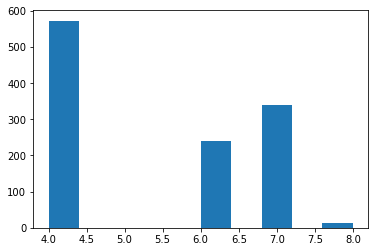

In [49]:
plt.hist(df2['Month'])

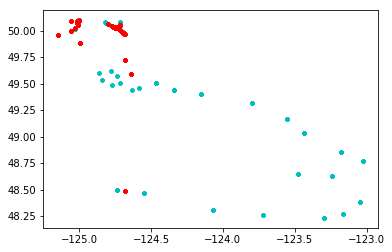

In [52]:

plt.plot(df2.loc[df2.Month<6,['Lon']],df2.loc[df2.Month<6,['Lat']],'c.')
plt.plot(df2.loc[df2.Month>6,['Lon']],df2.loc[df2.Month>6,['Lat']],'r.')